# Global Literacy Rates

## What Story?

### Potential Questions

* What is the male/female literacy by country? by geography? by income?
* What is the **gap** between male/female literacy by country? by geography? by income?
* Are countries that are geographically close together similar?
* How is the literacy rate increasing **over time**? 
    * Which gender is making more strides?
    * Is the rate plateauing? When was it boosted? What could have caused it? 

### Data Sources

* [Overall literacy rates](https://ourworldindata.org/grapher/literacy-rate-vs-gdp-per-capita)
* [Male literacy rates](https://data.worldbank.org/indicator/SE.ADT.LITR.MA.ZS?view=chart)
* [Female literacy rates](https://data.worldbank.org/indicator/SE.ADT.LITR.FE.ZS?name_desc=true&type=shaded&view=map)

### What Data? What Limitations?

* Sparse/missing data across the 10 years, especially on the country level. However, aggregates are fine. 
* There are high/mid/low income segments. Countries are mapped to these segments but not aggregates.
* Aggregates are not mutually exclusive. I would use the aggregates mentioned [in here](http://wdi.worldbank.org/table/2.10), ignoring groupings like IDA.

## Set Up

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# import scipy

## Gather Data

In [266]:
# Read data
regions = pd.read_csv("raw_data_region.csv")
male = pd.read_csv("raw_data_male.csv")
female = pd.read_csv("raw_data_female.csv")

In [267]:
# Clean column names
regions.columns = regions.columns.str.lower().str.replace(" ", "")
male.columns = male.columns.str.lower().str.replace(" ", "")
female.columns = female.columns.str.lower().str.replace(" ", "")

In [268]:
# Clean Regions with no "Region" column -- I manually curated the aggregates
regions = regions[~regions.region.isna()]

In [269]:
regions.groupby("region").count().iloc[:,0]

region
East Asia & Pacific           37
Europe & Central Asia         58
GROUP                          9
INCOME                         6
Latin America & Caribbean     42
Middle East & North Africa    21
North America                  3
REGION                        15
South Asia                     8
Sub-Saharan Africa            48
WORLD                          1
Name: countrycode, dtype: int64

In [270]:
regions.groupby("incomegroup", dropna=False).count().iloc[:,0]

incomegroup
High income            80
Low income             28
Lower middle income    54
Upper middle income    54
NaN                    32
Name: countrycode, dtype: int64

In [271]:
# Prioritize the aggregates that are already given. Maybe I can explore the other overlapping groupings if time.
regions[regions.region=="REGION"].tablename.unique()

r = list(regions.region.unique())
regions["is_region_aggregate"] = regions.apply(lambda x: 1 if x.tablename in r else 0, axis=1)

i = list(regions.incomegroup.unique())
regions["is_income_aggregate"] = regions.apply(lambda x: 1 if x.tablename in i else 0, axis=1)

In [272]:
# Unpivot data, do not drop missing data
years = [str(x) for x in np.arange(2010, 2021, 1)]  # 10 years we care about

male = pd.melt(male, id_vars=["countryname"], value_vars=years)
male.columns = ["countryname", "year", "literacy"]
male.sort_values(by=["countryname", "year"], inplace=True)
female = pd.melt(female, id_vars=["countryname"], value_vars=years)
female.columns = ["countryname", "year", "literacy"]
female.sort_values(by=["countryname", "year"], inplace=True)

In [273]:
# Join on regions, separate by segments
male = pd.merge(male, regions, left_on="countryname", right_on="tablename", how="inner")
female = pd.merge(female, regions, left_on="countryname", right_on="tablename", how="inner")

## Plot

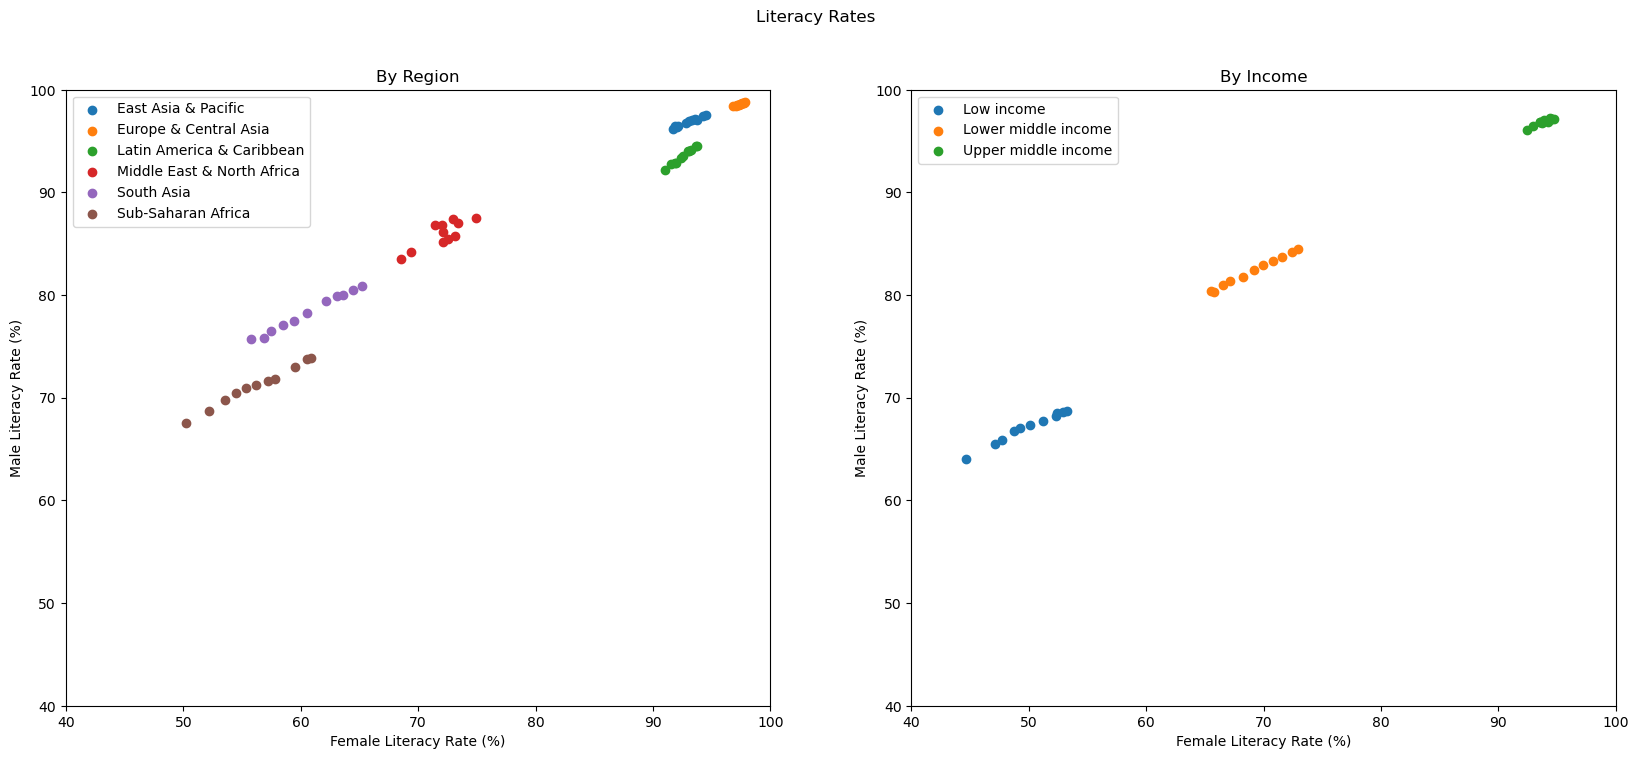

In [274]:
fig, axes = plt.subplots(1, 2, figsize=[20, 8])
fig.suptitle("Literacy Rates")

# Region
ax = axes[0]
ax.set_title("By Region")

y = male[(male.is_region_aggregate==1) & (male.literacy>0)]
x = female[(female.is_region_aggregate==1) & (female.literacy>0)]

for c in y.countryname.unique():
    ax.scatter(x[x.countryname==c].literacy, y[y.countryname==c].literacy)
ax.set_ylabel("Male Literacy Rate (%)")
ax.set_xlabel("Female Literacy Rate (%)")

ax.set_ylim([40, 100])
ax.set_xlim([40, 100])

ax.legend(y.countryname.unique())


# Income
ax = axes[1]
ax.set_title("By Income")

y = male[(male.is_income_aggregate==1) & (male.literacy>0)]
x = female[(female.is_income_aggregate==1) & (female.literacy>0)]

for c in y.countryname.unique():
    ax.scatter(x[x.countryname==c].literacy, y[y.countryname==c].literacy)
ax.set_ylabel("Male Literacy Rate (%)")
ax.set_xlabel("Female Literacy Rate (%)")

ax.set_ylim([40, 100])
ax.set_xlim([40, 100])

ax.legend(y.countryname.unique())


* Use slopes to show male-to-female literacy growth. For example, "when female literacy improves by 1%, male literacy improves by 5%."
* Use relative growth to show that countries with lower literacy starting point are growing faster. Countries with higher start point are plateauing.
* Use absolute growth to also show growth. For example, "all countries improved by at least 5% absolute for females."
* Use (female relative > male relative) to show that the gap is reducing for countries.

(0.0, 105.0)

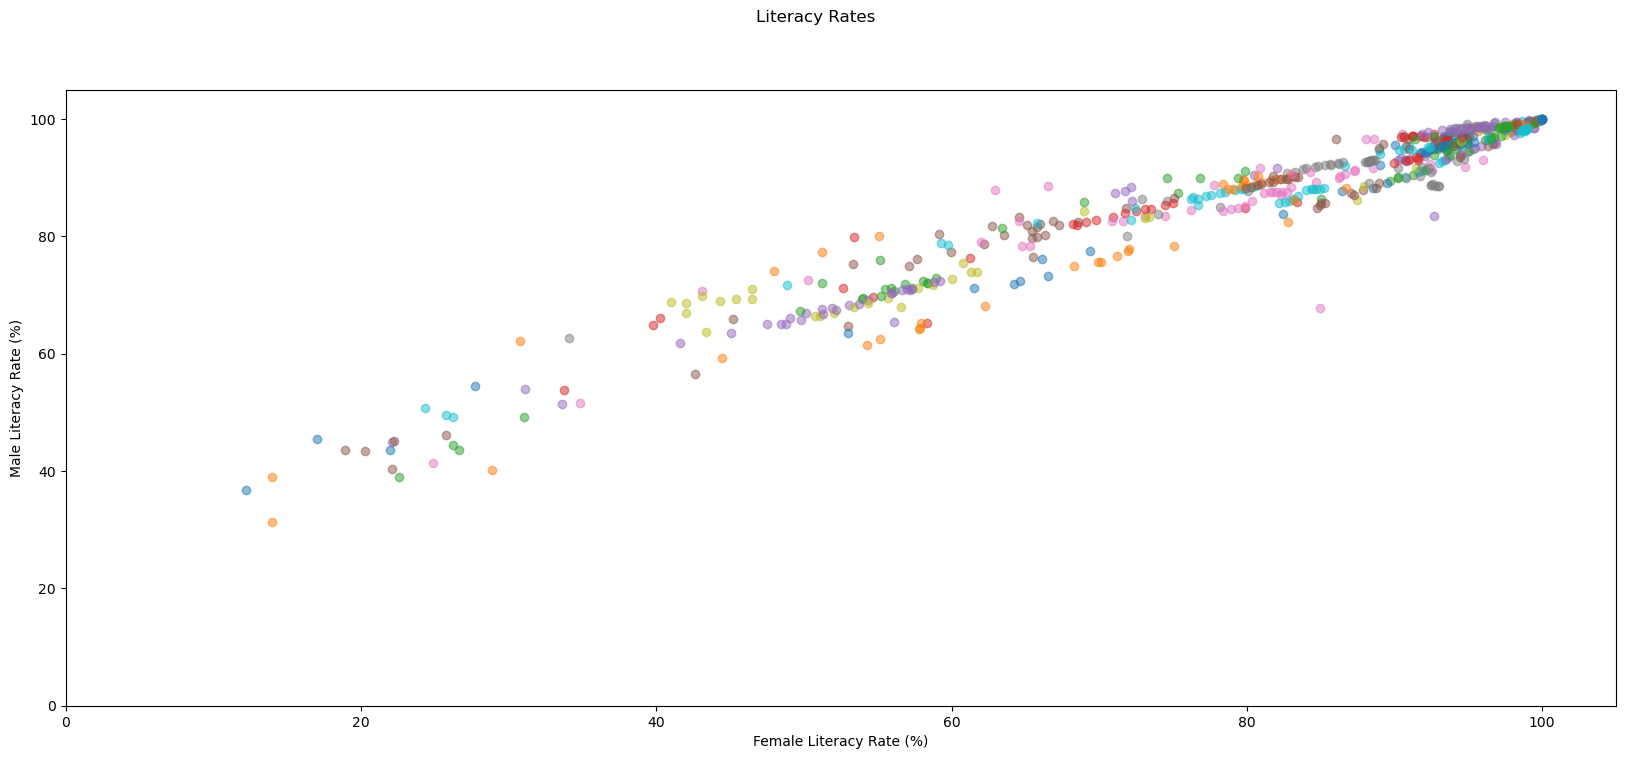

In [275]:
fig, ax = plt.subplots(1, 1, figsize=[20, 8])
fig.suptitle("Literacy Rates")

y = male[(male.is_region_aggregate==0) & (male.is_income_aggregate==0) & (male.literacy>0)]
x = female[(female.is_region_aggregate==0) & (female.is_income_aggregate==0) & (female.literacy>0)]

for c in y.countryname.unique():
    ax.scatter(x[x.countryname==c].literacy, y[y.countryname==c].literacy, alpha= 0.5)
ax.set_ylabel("Male Literacy Rate (%)")
ax.set_xlabel("Female Literacy Rate (%)")

ax.set_ylim([0, 105])
ax.set_xlim([0, 105])

* Most data points are concentrated at the top
* Movement happens drastically for countries starting at low literacy rate

In [276]:
combined = pd.merge(male, female, on=["countryname", "year"], suffixes=("_m", "_f"))

# Are there any years where female > male?
combined[combined.literacy_f > combined.literacy_m].describe()[["literacy_m", "literacy_f"]]

,literacy_m,literacy_f
count,93.000000,93.000000
mean,94.216065,95.243633
std,5.111698,3.922120
min,67.747467,82.779350
25%,91.168983,92.448112
50%,94.851830,95.469032
75%,98.371361,98.867462
max,99.993828,99.995873


## Fill in Missing Data

Options: forward fill, backward fill, mean interpolation

In [277]:
# SQL: COUNT(literacy) OVER(PARTITION BY countryname) AS country_num_years
male = male.assign(
    country_num_years=(
        male
        .groupby("countryname")  # OVER(PARTITION BY)
        .literacy
        .transform("count")  # COUNT()
    )
)

female = female.assign(
    country_num_years=(
        female
        .groupby("countryname")  # OVER(PARTITION BY)
        .literacy
        .transform("count")  # COUNT()
    )
)

In [278]:
x = (male[(male.country_num_years == 0)][["countryname", "is_region_aggregate", "is_income_aggregate"]].drop_duplicates())

# These aggregates need to be filled in using the average
print(x[x.is_region_aggregate==1].countryname.values)
print(x[x.is_income_aggregate==1].countryname.values)

['North America']
['High income']


In [279]:
# male[male.incomegroup=="High income"].groupby("year").mean().literacy
# male[male.region=="North America"].groupby("year").mean().literacy

* North America doesn't have any country with data ): Guess we have to discard this region entirely
* High income has data for mean interpolation

In [280]:
# Mean interpolation for high income
for y in years:
    ix = male[(male.countryname=="High income")&(male.is_income_aggregate==1)&(male.year==y)].index
    val = male[(male.incomegroup=="High income")&(male.year==y)].mean().literacy
    male.loc[ix, "literacy"] = val
    
    ix = female[(female.countryname=="High income")&(female.is_income_aggregate==1)&(female.year==y)].index
    val = female[(female.incomegroup=="High income")&(female.year==y)].mean().literacy
    female.loc[ix, "literacy"] = val

/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_3538/3192889656.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  val = male[(male.incomegroup=="High income")&(male.year==y)].mean().literacy
/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_3538/3192889656.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  val = female[(female.incomegroup=="High income")&(female.year==y)].mean().literacy


Text(0, 0.5, 'Number of countries')

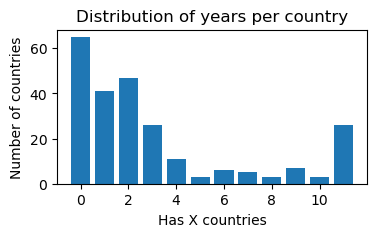

In [281]:
# How many countries have X years? 
tbl = male.groupby("countryname", as_index=False).count()[["countryname", "literacy"]].groupby("literacy", as_index=False).count()

fig, ax = plt.subplots(figsize=[4, 2])
ax.bar(x=tbl.literacy, height=tbl.countryname)
ax.set_title("Distribution of years per country")
ax.set_xlabel("Has X countries")
ax.set_ylabel("Number of countries")

* So many countries are missing data (0-1 years). We can throw out countries that are missing all data.
* For countries with only 1 year, we can skip the growth. (Trying a model/formula will take too long)
* For countries with at least 2 years, we can take the earliest and latest to calculate overall growth.

## Can we assume normality?

In [282]:
x = pd.DataFrame(country_data)
x.literacy_growth_abs_f.describe()

count    152.000000
mean       2.700043
std        4.586548
min      -13.238052
25%        0.000000
50%        1.190613
75%        4.074797
max       29.667957
Name: literacy_growth_abs_f, dtype: float64

In [283]:
max_years = (
    female
    [(female.is_region_aggregate==0)&(female.is_income_aggregate==0)&(female.literacy>0)&(~female.region.isin(["WORLD", "INCOME", "GROUP", "REGION"]))]
    .groupby(["countryname"], as_index=False)
    .max()
    [["countryname", "year"]]
)
x = pd.merge(female, max_years, how="inner")

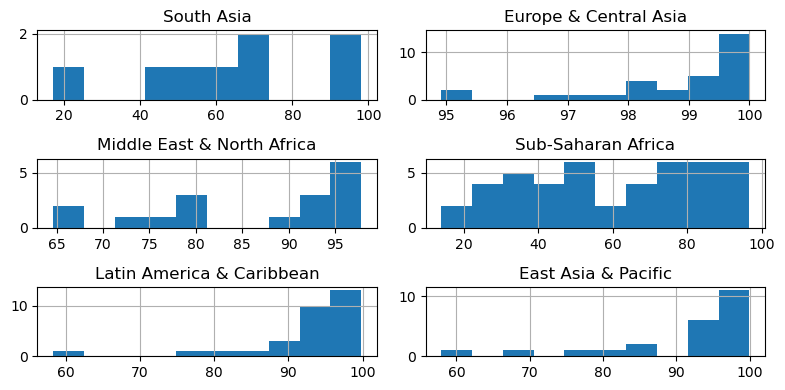

In [284]:
# Literacy is not really a normal distribution and low sample size for south asia...so can't compute by confidence intervals

fig, axes = plt.subplots(round(len(x.region.unique())/ 2), 2, figsize=[8, 4])
axes = axes.flatten()


for i, r in enumerate(x.region.unique()):
    x[x.region==r].literacy.hist(ax=axes[i])
    axes[i].set_title(r)
fig.tight_layout()

* Data is not normally distributed and the sample size is small. So we can try using IQR or median instead.

In [291]:
join_cols = ["countryname", "year", "region", "is_region_aggregate", "incomegroup", "is_income_aggregate", "countrycode", "specialnotes", "tablename", "country_num_years"]
combined = pd.merge(male, female, on=join_cols, suffixes=("_m", "_f"))
combined["gap"] = combined.literacy_m - combined.literacy_f

In [301]:
# Latest year is after 2015
# Take Median

maxyear = (
    combined
    [(combined.literacy_f > 0)&(combined.is_region_aggregate==0)&(combined.is_income_aggregate==0)]
    .groupby("countryname", as_index=False)
    .max()
    [["countryname", "year"]]
)
maxyear["is_max_year"] = 1

if "is_max_year" not in female.columns:
    combined = pd.merge(combined, maxyear, how="left")

region_median = (
    combined[(combined.is_max_year==1)&(combined.year.astype(int)>=2015)]
    .groupby("region")
    .quantile(.5, interpolation="midpoint")
    [["literacy_f", "gap"]]
)

region_median.rename(columns={"literacy_f": "literacy_f_median", "gap": "gap_median"}, inplace=True)
region_median

/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_3538/1945414267.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  combined[(combined.is_max_year==1)&(combined.year.astype(int)>=2015)]


,literacy_f_median,gap_median
region,,
East Asia & Pacific,95.321285,2.498180
Europe & Central Asia,99.451797,0.229324
GROUP,60.458759,12.749046
INCOME,81.846256,7.590103
Latin America & Caribbean,93.972771,0.014706
Middle East & North Africa,94.042049,2.996067
REGION,86.921829,3.719444
South Asia,65.790810,16.575897
Sub-Saharan Africa,56.063229,14.549858


* WORLD is `83.459137` female literacy rate
* WORLD is `6.704269` gender literacy rate gap

In [300]:
# How to look up
region_median.loc["WORLD"].literacy_f_median

83.45913696

## Create Dataset for D3

In [302]:
region_data = [
    {
        "name": region,
        "index": i,
        "literacy_f_median": region_median.loc[region].literacy_f_median,
        "gap_median": region_median.loc[region].gap_median,
        
        # Female
        "literacy_start_f": female[(female.countryname==region)&(female.year=="2010")].literacy.values[0],
        "literacy_end_f": female[(female.countryname==region)&(female.year=="2020")].literacy.values[0],
        "literacy_growth_abs_f": (
            female[(female.countryname==region)&(female.year=="2020")].literacy.values[0]
            - female[(female.countryname==region)&(female.year=="2010")].literacy.values[0]
        ),
        "literacy_growth_rel_f": 100 * (
            female[(female.countryname==region)&(female.year=="2020")].literacy.values[0]
            / female[(female.countryname==region)&(female.year=="2010")].literacy.values[0]
            - 1
        ),
        
        # Male
        "literacy_start_m": male[(male.countryname==region)&(male.year=="2010")].literacy.values[0],
        "literacy_end_m": male[(male.countryname==region)&(male.year=="2020")].literacy.values[0],
        "literacy_growth_abs_m": (
            male[(male.countryname==region)&(male.year=="2020")].literacy.values[0]
            - male[(male.countryname==region)&(male.year=="2010")].literacy.values[0]
        ),
        "literacy_growth_rel_m":  100 * (
            male[(male.countryname==region)&(male.year=="2020")].literacy.values[0]
            / male[(male.countryname==region)&(male.year=="2010")].literacy.values[0]
            - 1
        ),
        
        # Gap
        "literacy_start_gap": (
            male[(male.countryname==region)&(male.year=="2010")].literacy.values[0]
            - female[(female.countryname==region)&(female.year=="2010")].literacy.values[0]
        ),
        "literacy_end_gap": (
            male[(male.countryname==region)&(male.year=="2020")].literacy.values[0]
            - female[(female.countryname==region)&(female.year=="2020")].literacy.values[0]
        ),
        "literacy_growth_abs_gap": (
            (
                male[(male.countryname==region)&(male.year=="2020")].literacy.values[0]
                - female[(female.countryname==region)&(female.year=="2020")].literacy.values[0]
            )
            - (
                male[(male.countryname==region)&(male.year=="2010")].literacy.values[0]
                - female[(female.countryname==region)&(female.year=="2010")].literacy.values[0]
            )
        ),
        "literacy_growth_rel_gap":  100 * (
            (
                male[(male.countryname==region)&(male.year=="2020")].literacy.values[0]
                - female[(female.countryname==region)&(female.year=="2020")].literacy.values[0]
            )
            / (
                male[(male.countryname==region)&(male.year=="2010")].literacy.values[0]
                - female[(female.countryname==region)&(female.year=="2010")].literacy.values[0]
            )
            - 1
        ),
        
        # Data
        "data": [
            {
                "year": y,
                "year_index": k,
                "literacy_f": female[(female.countryname==region)&(female.year==y)].literacy.values[0],
                "literacy_m": male[(male.countryname==region)&(male.year==y)].literacy.values[0],
            }
            for k, y in enumerate(years)
        ],
    }
    # Exclude North America
    # Manually sort regions, I want to order by highest to lowest literacy
    # male[(male.is_region_aggregate==1)&(male.countryname!="North America")].countryname.unique()
    for i, region in enumerate(["Sub-Saharan Africa", "South Asia", "Middle East & North Africa", "Latin America & Caribbean", "East Asia & Pacific", "Europe & Central Asia"])
]

In [303]:
income_data = [
    {
        "name": income,
        "index": i,
        
        # Female
        "literacy_start_f": female[(female.countryname==income)&(female.year=="2010")].literacy.values[0],
        "literacy_end_f": female[(female.countryname==income)&(female.year=="2020")].literacy.values[0],
        "literacy_growth_abs_f": (
            female[(female.countryname==income)&(female.year=="2020")].literacy.values[0]
            - female[(female.countryname==income)&(female.year=="2010")].literacy.values[0]
        ),
        "literacy_growth_rel_f": 100 * (
            female[(female.countryname==income)&(female.year=="2020")].literacy.values[0]
            / female[(female.countryname==income)&(female.year=="2010")].literacy.values[0]
            - 1
        ),
        
        # Male
        "literacy_start_m": male[(male.countryname==income)&(male.year=="2010")].literacy.values[0],
        "literacy_end_m": male[(male.countryname==income)&(male.year=="2020")].literacy.values[0],
        "literacy_growth_abs_m": (
            male[(male.countryname==income)&(male.year=="2020")].literacy.values[0]
            - male[(male.countryname==income)&(male.year=="2010")].literacy.values[0]
        ),
        "literacy_growth_rel_m":  100 * (
            male[(male.countryname==income)&(male.year=="2020")].literacy.values[0]
            / male[(male.countryname==income)&(male.year=="2010")].literacy.values[0]
            - 1
        ),
        
        # Gap
        "literacy_start_gap": (
            male[(male.countryname==income)&(male.year=="2010")].literacy.values[0]
            - female[(female.countryname==income)&(female.year=="2010")].literacy.values[0]
        ),
        "literacy_end_gap": (
            male[(male.countryname==income)&(male.year=="2020")].literacy.values[0]
            - female[(female.countryname==income)&(female.year=="2020")].literacy.values[0]
        ),
        "literacy_growth_abs_gap": (
            (
                male[(male.countryname==income)&(male.year=="2020")].literacy.values[0]
                - female[(female.countryname==income)&(female.year=="2020")].literacy.values[0]
            )
            - (
                male[(male.countryname==income)&(male.year=="2010")].literacy.values[0]
                - female[(female.countryname==income)&(female.year=="2010")].literacy.values[0]
            )
        ),
        "literacy_growth_rel_gap":  100 * (
            (
                male[(male.countryname==income)&(male.year=="2020")].literacy.values[0]
                - female[(female.countryname==income)&(female.year=="2020")].literacy.values[0]
            )
            / (
                male[(male.countryname==income)&(male.year=="2010")].literacy.values[0]
                - female[(female.countryname==income)&(female.year=="2010")].literacy.values[0]
            )
            - 1
        ),
        
        # Data
        "data": [
            {
                "year": y,
                "year_index": k,
                "literacy_f": female[(female.countryname==income)&(female.year==y)].literacy.values[0],
                "literacy_m": male[(male.countryname==income)&(male.year==y)].literacy.values[0],
            }
            for k, y in enumerate(years)
        ],
    }
    # Manually sort income, since they are ordinal
    # male[male.is_income_aggregate==1].countryname.unique()
    for i, income in enumerate(["Low income", "Lower middle income", "Upper middle income", "High income",])
]

In [305]:
country_data = [
    {
        "name": country,
        "index": i,
        "region": male[(male.countryname==country)].region.values[0],
        "income": male[(male.countryname==country)].incomegroup.values[0],
        
        "year_start": int(female[(female.countryname==country)&(female.literacy>0)].year.min()),
        "year_end": int(female[(female.countryname==country)&(female.literacy>0)].year.max()),
        "num_years": int(female[(female.countryname==country)&(female.literacy>0)].year.count()),
        
        # Female
        "literacy_start_f": (
            female[
                (female.countryname==country)
                &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())
            ]
            .literacy
            .values[0]                
        ),
        "literacy_end_f": (
            female[
                (female.countryname==country)
                &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())
            ]
            .literacy
            .values[0]                
        ),
        "literacy_growth_abs_f": (
            (
                female[
                    (female.countryname==country)
                    &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())
                ]
                .literacy
                .values[0]                
            )
            - (
                female[
                    (female.countryname==country)
                    &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())
                ]
                .literacy
                .values[0]                
            )
        ),
        "literacy_growth_rel_f": 100 * (
            (
                female[
                    (female.countryname==country)
                    &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())
                ]
                .literacy
                .values[0]                
            )
            / (
                female[
                    (female.countryname==country)
                    &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())
                ]
                .literacy
                .values[0]                
            )
            - 1
        ),
        
        # Male
        "literacy_start_m": (
            male[
                (male.countryname==country)
                &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())
            ]
            .literacy
            .values[0]                
        ),
        "literacy_end_m": (
            male[
                (male.countryname==country)
                &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())
            ]
            .literacy
            .values[0]                
        ),
        "literacy_growth_abs_m": (
            (
                male[
                    (male.countryname==country)
                    &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())
                ]
                .literacy
                .values[0]                
            )
            - (
                male[
                    (male.countryname==country)
                    &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())
                ]
                .literacy
                .values[0]                
            )
        ),
        "literacy_growth_rel_m": 100 * (
            (
                male[
                    (male.countryname==country)
                    &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())
                ]
                .literacy
                .values[0]                
            )
            / (
                male[
                    (male.countryname==country)
                    &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())
                ]
                .literacy
                .values[0]                
            )
            - 1
        ),
        
        # Gap
        "literacy_start_gap": (
            male[(male.countryname==country)&(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())].literacy.values[0]
            - female[(female.countryname==country)&(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())].literacy.values[0]
        ),
        "literacy_end_gap": (
            male[(male.countryname==country)&(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())].literacy.values[0]
            - female[(female.countryname==country)&(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())].literacy.values[0]
        ),
        "literacy_growth_abs_gap": (
            (
                male[(male.countryname==country)&(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())].literacy.values[0]
                - female[(female.countryname==country)&(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())].literacy.values[0]
            )
            - (
                male[(male.countryname==country)&(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())].literacy.values[0]
                - female[(female.countryname==country)&(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())].literacy.values[0]
            )
        ),
        "literacy_growth_rel_gap":  100 * np.nan_to_num(
            (
                male[(male.countryname==country)&(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())].literacy.values[0]
                - female[(female.countryname==country)&(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())].literacy.values[0]
            )
            / (
                male[(male.countryname==country)&(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())].literacy.values[0]
                - female[(female.countryname==country)&(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())].literacy.values[0]
            )
            - 1
        ),
        
        # Region
        "region_literacy_end_f": female[(female.countryname==female[(female.countryname==country)].region.values[0])&(female.year=="2020")].literacy.values[0],
        "region_literacy_end_m": male[(male.countryname==male[(male.countryname==country)].region.values[0])&(male.year=="2020")].literacy.values[0],
        
        # Data
        "data": [
            {
                "year": int(y),
                "year_index": k,
                "income": female[(female.countryname==country)&(female.year==y)].incomegroup.values[0],
                "region": female[(female.countryname==country)&(female.year==y)].region.values[0],
                "literacy_f": female[(female.countryname==country)&(female.year==y)].literacy.values[0],
                "literacy_m": male[(male.countryname==country)&(male.year==y)].literacy.values[0],
                "country_all_years_abs_growth_f":100 * (
                    (
                        female[
                            (female.countryname==country)
                            &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.max())
                        ]
                        .literacy
                        .values[0]                
                    )
                    / (
                        female[
                            (female.countryname==country)
                            &(female.year==female[(female.countryname==country)&(female.literacy>0)].year.min())
                        ]
                        .literacy
                        .values[0]                
                    )
                    - 1
                ),
                "country_all_years_abs_growth_m":100 * (
                    (
                        male[
                            (male.countryname==country)
                            &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.max())
                        ]
                        .literacy
                        .values[0]                
                    )
                    / (
                        male[
                            (male.countryname==country)
                            &(male.year==male[(male.countryname==country)&(male.literacy>0)].year.min())
                        ]
                        .literacy
                        .values[0]                
                    )
                    - 1
                ),
                
            }
            for k, y in enumerate(years)
            if male[(male.countryname==country)&(male.year==y)&(male.literacy>0)].shape[0] > 0  # Skip if no data for that year
        ],
    }
    # Skip if the country has no data at all
    for i, country in enumerate(male[
        (male.country_num_years > 0)
        &(male.is_region_aggregate==0)
        &(male.is_income_aggregate==0)
        &(male.incomegroup.isin(male[male.is_income_aggregate==1].countryname.unique()))
        &(male.region.isin(male[male.is_region_aggregate==1].countryname.unique()))
    ].countryname.unique())
]

/var/folders/qf/dsrk08sd51dcgwp2fp8wpt8w0000gn/T/ipykernel_3538/846253204.py:142: RuntimeWarning: invalid value encountered in double_scalars
  (


In [306]:
# x = pd.DataFrame(country_data)
# x[x.name=="Barbados"]  # M and F are exactly the same so relative growth in gap cannot be calculated --> use np.nan_to_num()

In [307]:
data = {
    "region": region_data,
    "income": income_data,
    "country": country_data,
}

In [308]:
with open("data.json", "w") as file:
    json.dump(data, file)

In [314]:
combined[~combined.incomegroup.isna()].sort_values(by="gap").head()

,countryname,year,literacy_m,countrycode,region,incomegroup,specialnotes,tablename,is_region_aggregate,is_income_aggregate,country_num_years,literacy_f,gap,is_max_year
1368,Lesotho,2014,67.747467,LSO,Sub-Saharan Africa,Lower middle income,Fiscal year end: March 31; reporting period fo...,Lesotho,0,0,1,84.934891,-17.187424,1.0
1192,Jamaica,2014,83.440002,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,92.699997,-9.259995,1.0
1530,Malta,2011,91.792648,MLT,Middle East & North Africa,High income,A simple multiplier is used to convert the nat...,Malta,0,0,2,94.790039,-2.997391,NaN
1537,Malta,2018,93.009972,MLT,Middle East & North Africa,High income,A simple multiplier is used to convert the nat...,Malta,0,0,2,95.988724,-2.978752,1.0
2009,Qatar,2017,93.144463,QAT,Middle East & North Africa,High income,NaN,Qatar,0,0,7,94.711510,-1.567047,1.0


In [311]:
combined[combined.tablename=="Jamaica"]

,countryname,year,literacy_m,countrycode,region,incomegroup,specialnotes,tablename,is_region_aggregate,is_income_aggregate,country_num_years,literacy_f,gap,is_max_year
1188,Jamaica,2010,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1189,Jamaica,2011,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1190,Jamaica,2012,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1191,Jamaica,2013,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1192,Jamaica,2014,83.440002,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,92.699997,-9.259995,1.0
1193,Jamaica,2015,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1194,Jamaica,2016,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1195,Jamaica,2017,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1196,Jamaica,2018,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
1197,Jamaica,2019,NaN,JAM,Latin America & Caribbean,Upper middle income,NaN,Jamaica,0,0,1,NaN,NaN,NaN
